# Yarden's Part - SARIMA

## Basic Set Up

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

## EDA

In [27]:
data = pd.read_csv('data_final/with_xal.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data.head(10)

,Close,Crude Oil Price,Jet Fuel Price,Revenue,Net Income,S&P 500,XAL,set
Date,,,,,,,,
2014-11-24,0.990156,0.892607,0.963011,0.443391,0.338313,0.170333,0.405661,train
2014-11-25,1.011697,0.859307,0.942245,0.439180,0.337336,0.168646,0.417473,train
2014-11-26,1.030487,0.855478,0.903310,0.434969,0.336358,0.172757,0.423893,train
2014-11-28,1.112064,0.763903,0.792992,0.426547,0.334403,0.169022,0.497936,train
2014-12-01,1.097169,0.746920,0.832576,0.413914,0.331471,0.159015,0.462012,train
2014-12-02,1.096711,0.751249,0.793640,0.409703,0.330493,0.168306,0.457845,train
2014-12-03,1.105419,0.734599,0.779364,0.405492,0.329516,0.173820,0.469675,train
2014-12-04,1.137729,0.707126,0.791694,0.401281,0.328538,0.172112,0.503550,train
2014-12-05,1.168893,0.699134,0.781960,0.397070,0.327561,0.174557,0.526998,train


In [28]:
AAL = data['Close']
AAL.head(10)

Date
2014-11-24    0.990156
2014-11-25    1.011697
2014-11-26    1.030487
2014-11-28    1.112064
2014-12-01    1.097169
2014-12-02    1.096711
2014-12-03    1.105419
2014-12-04    1.137729
2014-12-05    1.168893
2014-12-08    1.164539
Name: Close, dtype: float64

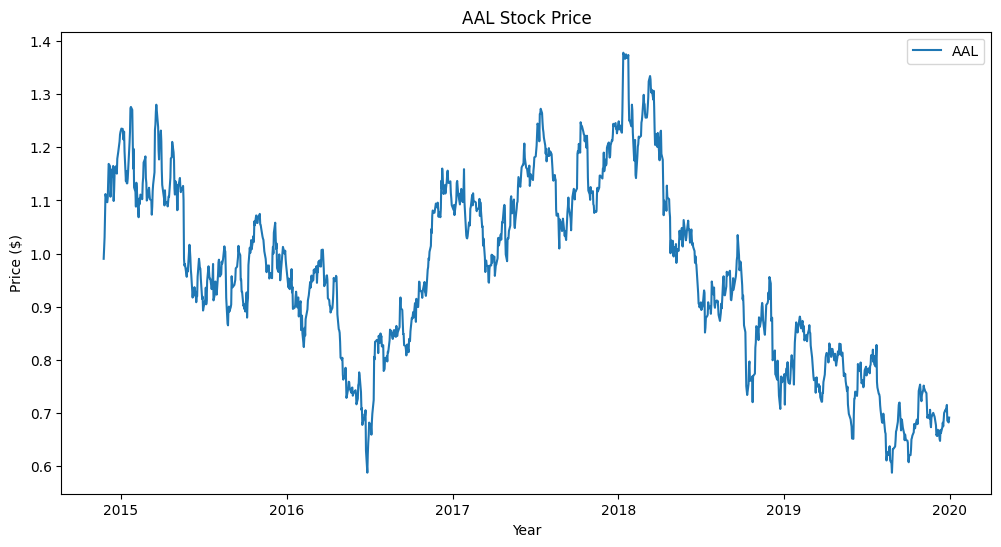

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(AAL)
plt.title('AAL Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend(['AAL'])
plt.show()

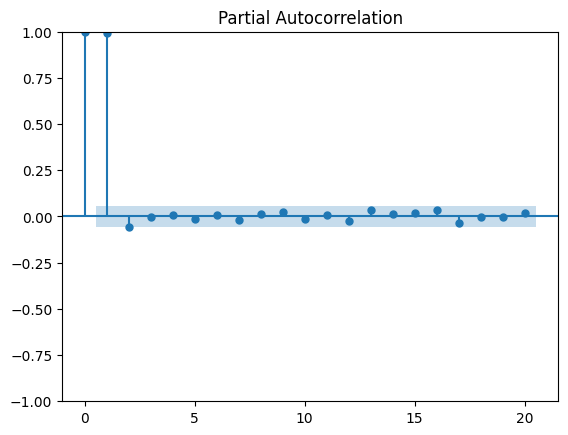

In [30]:
tsaplots.plot_pacf(AAL, lags=20);

In [31]:
AAL_diff = AAL.diff(periods=1).dropna()

As seen in the above graph, only the first term is non-zero. Therefore, we try differencing with $d=1$, i.e. we define the differenced series $Z_t = X_t - X_{t-1}$.

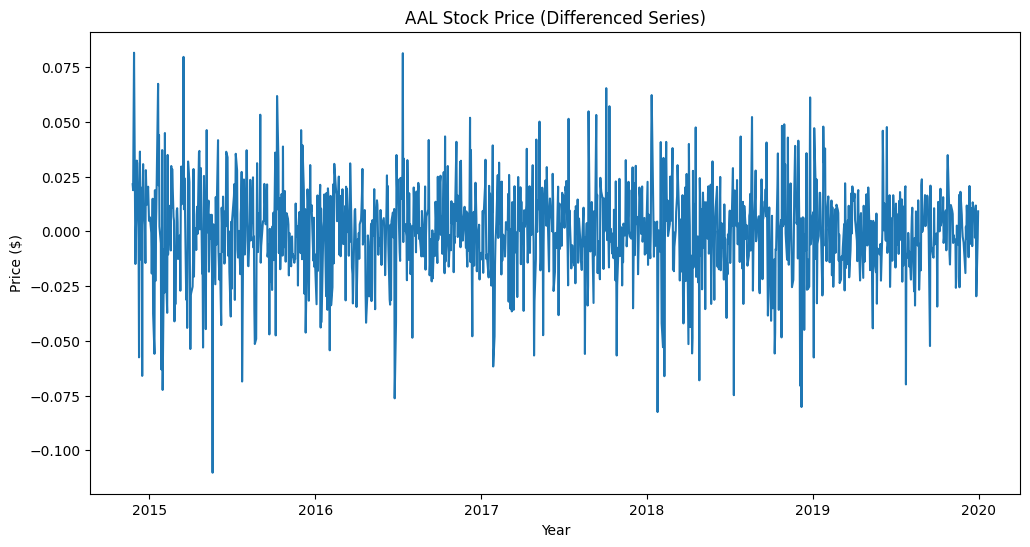

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(AAL_diff)
plt.title('AAL Stock Price (Differenced Series)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show()

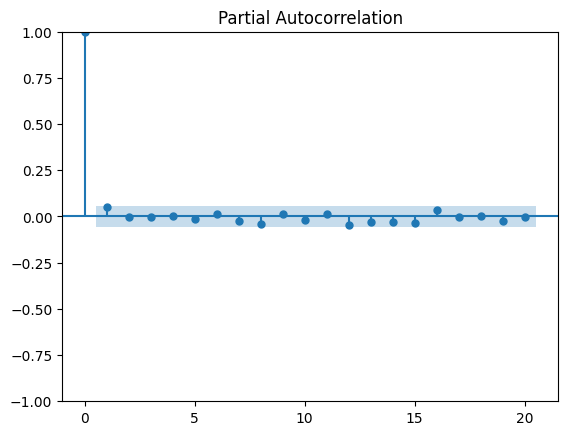

In [33]:
tsaplots.plot_pacf(AAL_diff, lags=20);

## SARIMA

### Dividing to Train, Validation and Test

In [34]:
train = AAL[data['set'] == 'train']
test = AAL[data['set'] == 'test']

In [35]:
def plot_predictions(train, test, predictions, model):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Predictions', color='red')
    plt.title('AAL Stock Price Predictions ' + model)
    plt.xlabel('Year')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

### Fitting SARIMA Model

As seen in the EDA, the differenced series mitigates the trednd present in the original data. Therefore, we fit a SARIMA model to the differenced series.

In [36]:
auto_sarima_model = auto_arima(train, seasonal=True, m = 5,
                               d = 1, D = 1, 
                               start_p = 0, start_q = 0, max_p = 4, max_q = 4,
                               start_P = 0, start_Q = 0, max_P = 4, max_Q = 4,
                               trace=True, error_action='warn', suppress_warnings=True,
                               random_state=42, n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-3904.183, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-4185.811, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-3905.748, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-4301.268, Time=0.65 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=-4367.487, Time=1.12 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=-4398.159, Time=0.86 sec
 ARIMA(1,1,0)(4,1,1)[5]             : AIC=inf, Time=4.66 sec
 ARIMA(1,1,0)(3,1,1)[5]             : AIC=inf, Time=2.64 sec
 ARIMA(0,1,0)(4,1,0)[5]             : AIC=-4397.793, Time=0.96 sec
 ARIMA(2,1,0)(4,1,0)[5]             : AIC=-4396.221, Time=2.31 sec
 ARIMA(1,1,1)(4,1,0)[5]             : AIC=-4396.001, Time=2.40 sec
 ARIMA(0,1,1)(4,1,0)[5]             : AIC=-4398.126, Time=1.96 sec
 ARIMA(2,1,1)(4,1,0)[5]             : AIC=-4394.204, Time=2.41 sec
 ARIMA(1,1,0)(4,1,0)[5] intercept   :

In [37]:
AAL_model = SARIMAX(train, order=auto_sarima_model.order, seasonal_order=auto_sarima_model.seasonal_order)
AAL_fit = AAL_model.fit(disp=False)
AAL_pred = AAL_fit.get_forecast(steps=len(test))
print(AAL_fit.summary())

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  963
Model:             SARIMAX(1, 1, 0)x(4, 1, 0, 5)   Log Likelihood                2205.080
Date:                           Sat, 30 Nov 2024   AIC                          -4398.159
Time:                                   18:20:27   BIC                          -4368.976
Sample:                                        0   HQIC                         -4387.044
                                           - 963                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0490      0.031      1.586      0.113      -0.012       0.109
ar.S.L5       -0.8189      0.030    -27.154

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


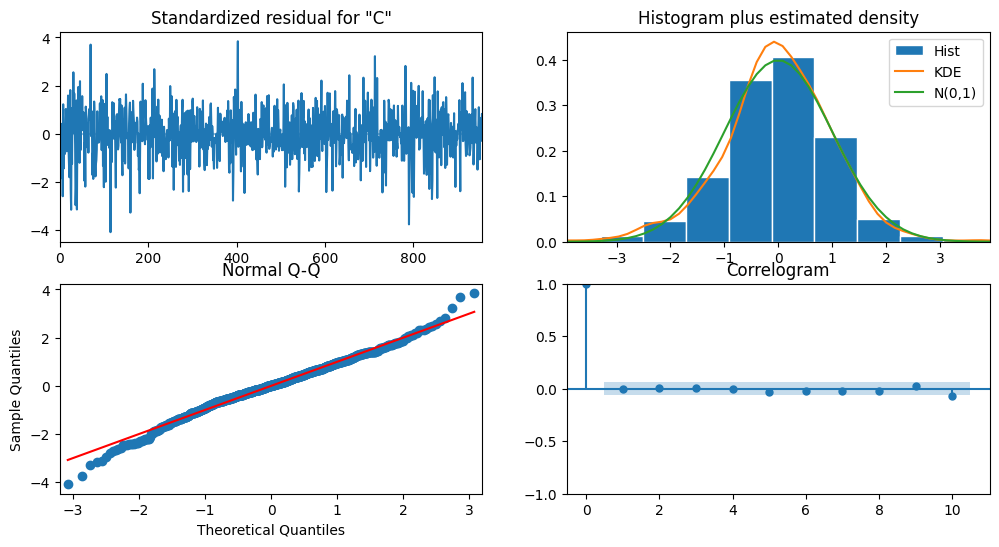

In [38]:
AAL_fit.plot_diagnostics(figsize=(12, 6));

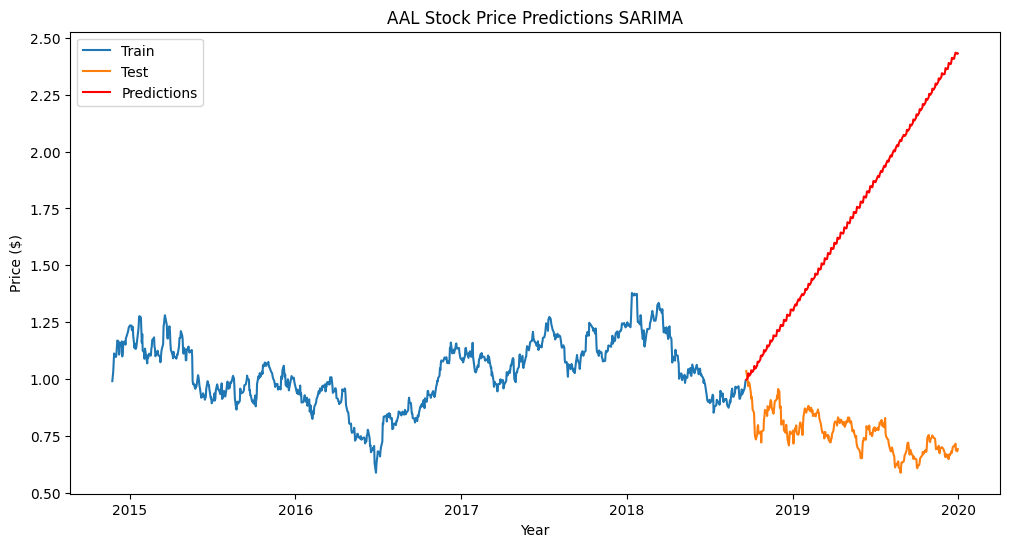

In [39]:
AAL_pred_indexed = AAL_pred.predicted_mean
AAL_pred_indexed.index = test.index
plot_predictions(train, test, AAL_pred_indexed, 'SARIMA')

### RMSE

In [40]:
def calc_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

## Without Exogenous Data

### Predictions with Horizon

In [ ]:
def h_step_prediction(h, train, test, fitted_model):
    # Create a copy of the train data to append the predictions
    extended_train = copy.deepcopy(train)
    predictions = pd.DataFrame(columns=['Prediction', 'SD', 'Lower_CI', 'Upper_CI'])

    # Augment the test set with the last h points from the training set
    augmented_test = pd.concat([train[-h:], test])

    for test_index in range(len(augmented_test)):
        # Predict exactly h steps ahead
        forecast = fitted_model.get_forecast(steps=h)
        forecast_mean = forecast.predicted_mean  # Extract the forecasted values
        forecast_sd = forecast.se_mean  # Standard deviation of the predictions
        forecast_conf_int = forecast.conf_int(alpha=0.2)  # 90% confidence intervals

        # Store the prediction for the current test point (h days ahead)
        current_prediction = forecast_mean.iloc[-1]  # The h'th value in the forecast
        current_sd = forecast_sd.iloc[-1]  # Standard deviation for the h'th step
        lower_ci = forecast_conf_int.iloc[-1, 0]  # Lower bound of 95% CI for the h'th step
        upper_ci = forecast_conf_int.iloc[-1, 1]  # Upper bound of 95% CI for the h'th step

        # Add the prediction and associated stats to the DataFrame
        predictions.loc[augmented_test.index[test_index]] = {
            'Prediction': current_prediction,
            'SD': current_sd,
            'Lower_CI': lower_ci,
            'Upper_CI': upper_ci
        }

        # Add the next real data point from the augmented test set to the training set
        extended_train.at[augmented_test.index[test_index]] = augmented_test.iloc[test_index]

        # Refit the model with the extended training data
        fitted_model = SARIMAX(
            extended_train,
            order=fitted_model.model.order,
            seasonal_order=fitted_model.model.seasonal_order
        ).fit(disp=False)

    return predictions
    

### One Day Ahead

In [42]:
oda_pred = h_step_prediction(1, train, test, copy.deepcopy(AAL_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

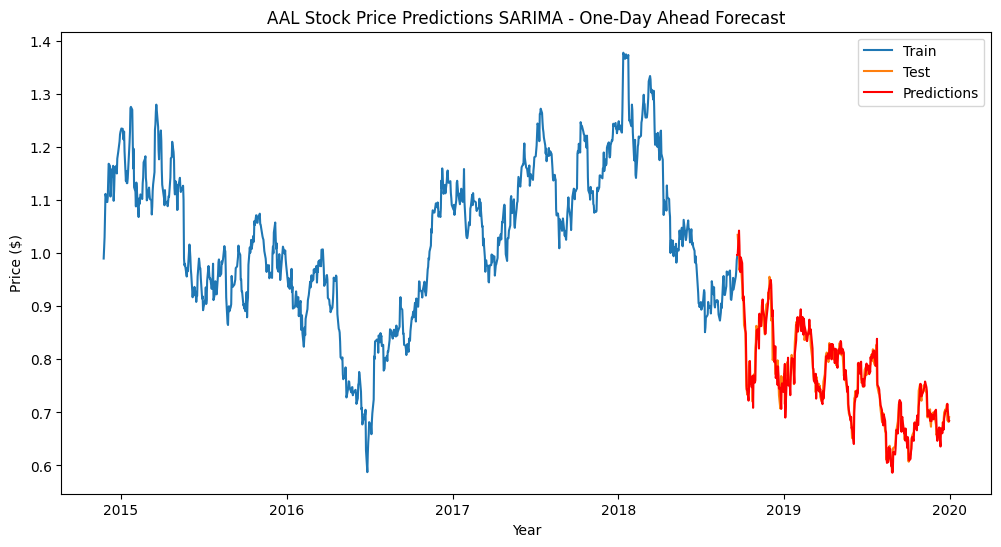

In [43]:
plot_predictions(train, test, oda_pred['Prediction'], 'SARIMA - One-Day Ahead Forecast')

In [44]:
rmse_oda = calc_rmse(test, oda_pred['Prediction'])
print(f'RMSE of One-Day Ahead Forecast: {rmse_oda}')

RMSE of One-Day Ahead Forecast: 0.022040466956687328


### One Week Ahead

In [45]:
fda_pred = h_step_prediction(5, train, test, copy.deepcopy(AAL_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

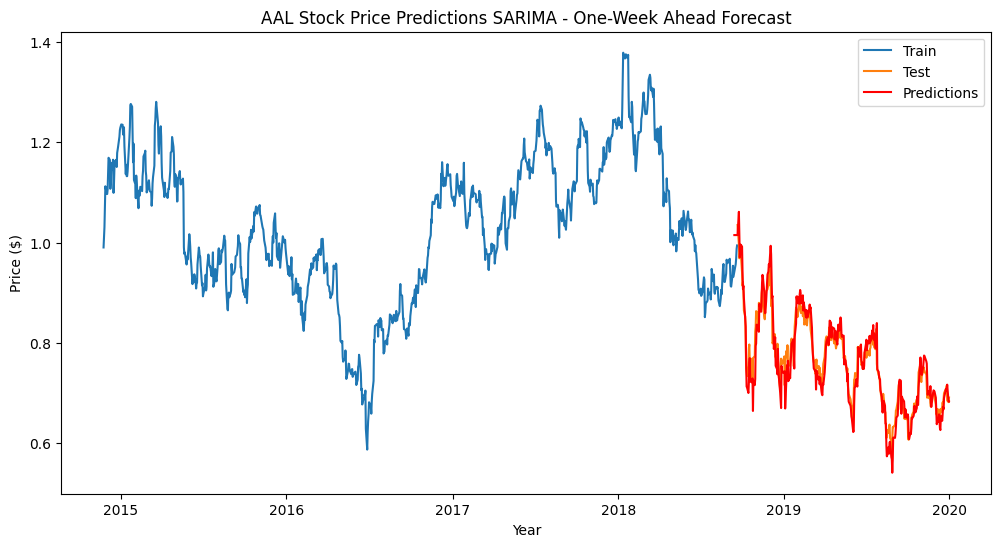

In [46]:
plot_predictions(train, test, fda_pred['Prediction'], 'SARIMA - One-Week Ahead Forecast')

In [47]:
rmse_fda = calc_rmse(test, fda_pred['Prediction'])
print(f'RMSE of One-Week Ahead Forecast: {rmse_fda}')

RMSE of One-Week Ahead Forecast: 0.02895671788023157


### One Month Ahead

In [48]:
oma_pred = h_step_prediction(21, train, test, copy.deepcopy(AAL_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

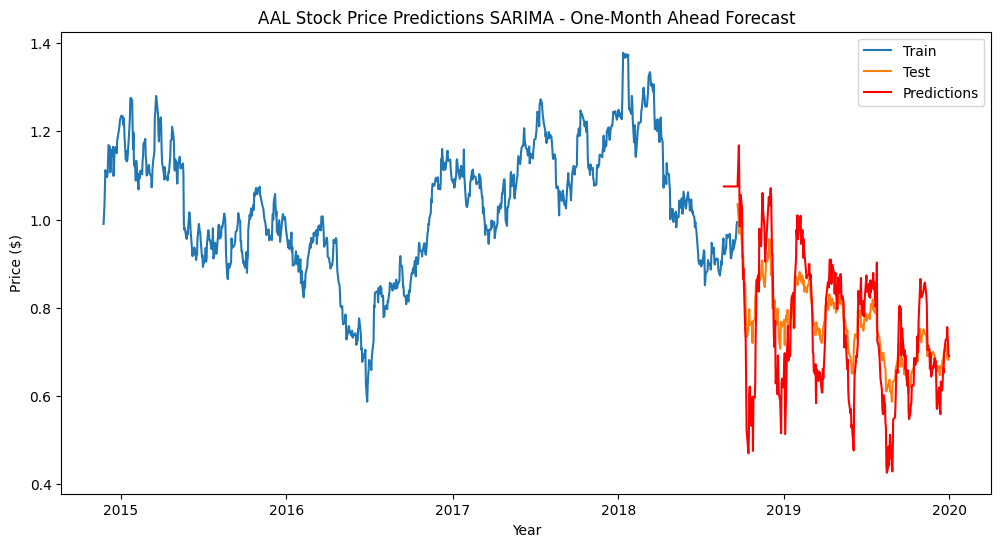

In [49]:
plot_predictions(train, test, oma_pred['Prediction'], 'SARIMA - One-Month Ahead Forecast')

In [50]:
rmse_oma = calc_rmse(test, oma_pred['Prediction'])
print(f'RMSE of One-Month Ahead Forecast: {rmse_oma}')

RMSE of One-Month Ahead Forecast: 0.09448151106167493


## With Exogenous Data

### Dividing to Train and Test

In [51]:
exogenous_data = data[['Crude Oil Price', 'Jet Fuel Price' ,'Revenue', 'Net Income', 'S&P 500', 'XAL']]
exogenous_train = exogenous_data[data['set'] == 'train']
exogenous_test = exogenous_data[data['set'] == 'test']

### Fitting a SARIMA Model

In [52]:
exogenous_auto_sarima_model = auto_arima(train, exogenous=exogenous_train, seasonal=True, m = 5,
                                            d = 1, D = 1, 
                                            start_p = 0, start_q = 0, max_p = 4, max_q = 4,
                                            start_P = 0, start_Q = 0, max_P = 4, max_Q = 4,
                                            trace=True, error_action='warn', suppress_warnings=True,
                                            random_state=42, n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-3904.183, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-4185.811, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-3905.748, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-4301.268, Time=0.62 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=-4367.487, Time=0.76 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=-4398.159, Time=0.83 sec
 ARIMA(1,1,0)(4,1,1)[5]             : AIC=inf, Time=4.08 sec
 ARIMA(1,1,0)(3,1,1)[5]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(4,1,0)[5]             : AIC=-4397.793, Time=0.96 sec
 ARIMA(2,1,0)(4,1,0)[5]             : AIC=-4396.221, Time=2.41 sec
 ARIMA(1,1,1)(4,1,0)[5]             : AIC=-4396.001, Time=2.40 sec
 ARIMA(0,1,1)(4,1,0)[5]             : AIC=-4398.126, Time=1.95 sec
 ARIMA(2,1,1)(4,1,0)[5]             : AIC=-4394.204, Time=2.19 sec
 ARIMA(1,1,0)(4,1,0)[5] intercept   :

In [53]:
AAL_exogenous_model = SARIMAX(train, exogenous=exogenous_train, order=exogenous_auto_sarima_model.order, seasonal_order=exogenous_auto_sarima_model.seasonal_order)
AAL_exogenous_fit = AAL_exogenous_model.fit(disp=False)
AAL_exogenous_pred = AAL_exogenous_fit.get_forecast(steps=len(test), exogenous=exogenous_test)
print(AAL_exogenous_fit.summary())

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  963
Model:             SARIMAX(1, 1, 0)x(4, 1, 0, 5)   Log Likelihood                2205.080
Date:                           Sat, 30 Nov 2024   AIC                          -4398.159
Time:                                   18:44:31   BIC                          -4368.976
Sample:                                        0   HQIC                         -4387.044
                                           - 963                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0490      0.031      1.586      0.113      -0.012       0.109
ar.S.L5       -0.8189      0.030    -27.154

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


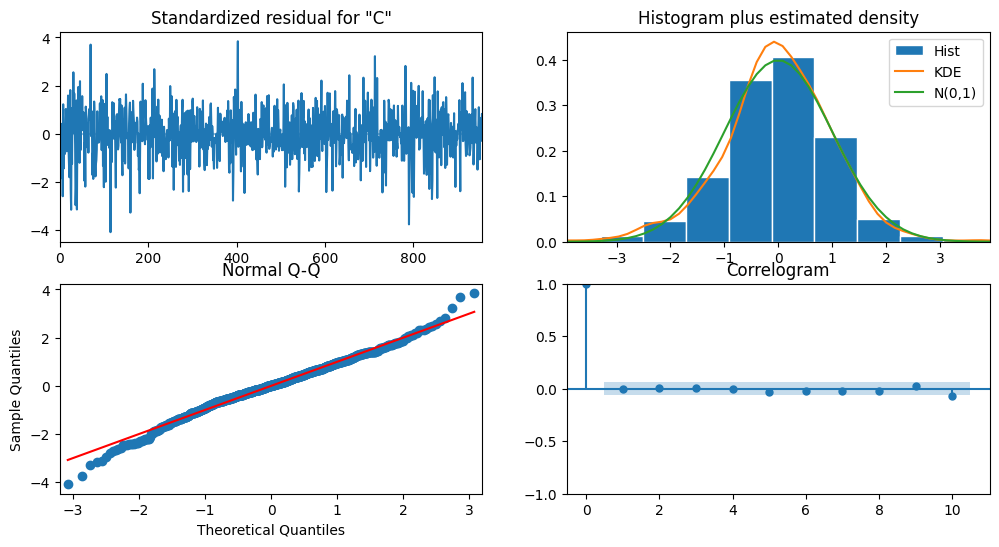

In [54]:
AAL_exogenous_fit.plot_diagnostics(figsize=(12, 6));

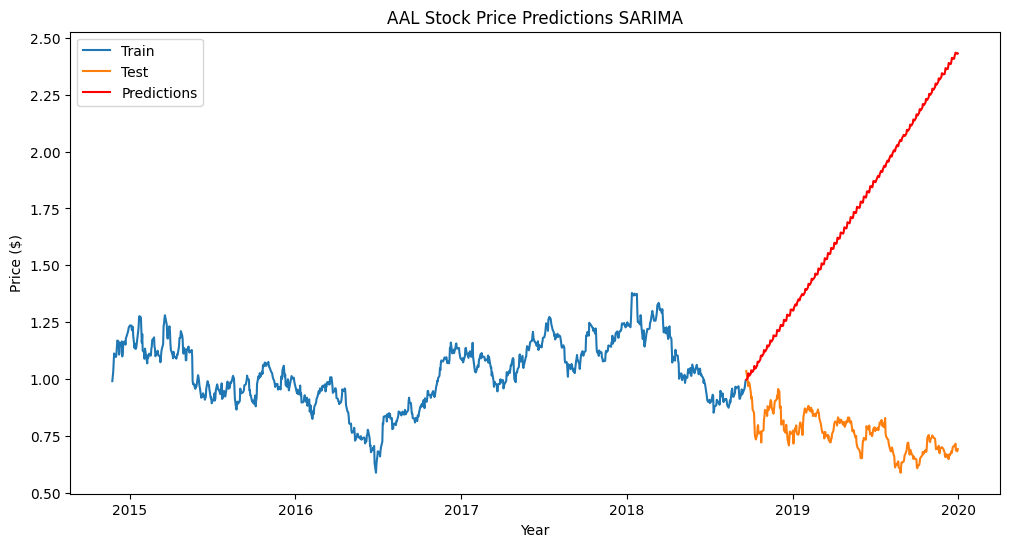

In [55]:
AAL_exogenous_pred_indexed = AAL_exogenous_pred.predicted_mean
AAL_exogenous_pred_indexed.index = test.index
plot_predictions(train, test, AAL_exogenous_pred_indexed, 'SARIMA')

### Predictions with Horizon

In [ ]:
def h_step_prediction_exogenous(h, train, test, exog_train, exog_test, fitted_model):
    # Create copies of train and exogenous data to append predictions
    extended_train = copy.deepcopy(train)
    extended_exog_train = copy.deepcopy(exog_train)
    predictions = pd.DataFrame(columns=['Prediction', 'SD', 'Lower_CI', 'Upper_CI'])

    # Augment the test set and exogenous data with the last h points from the training set
    augmented_test = pd.concat([train[-h:], test])
    augmented_exog_test = pd.concat([exog_train.iloc[-h:], exog_test])

    for test_index in range(len(augmented_test)):
        # Predict exactly h steps ahead using the last h rows of exogenous variables
        forecast = fitted_model.get_forecast(steps=h, exog=extended_exog_train.iloc[-h:])
        forecast_mean = forecast.predicted_mean  # Extract the forecasted values
        forecast_sd = forecast.se_mean  # Standard deviation of the predictions
        forecast_conf_int = forecast.conf_int(alpha=0.2)  # 95% confidence intervals

        # Store the prediction and associated stats for the current test point (h days ahead)
        current_prediction = forecast_mean.iloc[-1]  # The h'th value in the forecast
        current_sd = forecast_sd.iloc[-1]  # Standard deviation for the h'th step
        lower_ci = forecast_conf_int.iloc[-1, 0]  # Lower bound of 95% CI for the h'th step
        upper_ci = forecast_conf_int.iloc[-1, 1]  # Upper bound of 95% CI for the h'th step

        # Add the prediction and associated stats to the DataFrame
        predictions.loc[augmented_test.index[test_index]] = {
            'Prediction': current_prediction,
            'SD': current_sd,
            'Lower_CI': lower_ci,
            'Upper_CI': upper_ci
        }

        # Add the next real data point and its exogenous variables to the training set
        extended_train.at[augmented_test.index[test_index]] = augmented_test.iloc[test_index]
        extended_exog_train.loc[augmented_test.index[test_index]] = augmented_exog_test.iloc[test_index]

        # Refit the model with the extended training data and exogenous variables
        fitted_model = SARIMAX(
            extended_train,
            exog=extended_exog_train,
            order=fitted_model.model.order,
            seasonal_order=fitted_model.model.seasonal_order
        ).fit(disp=False)

    return predictions

### One Day Ahead

In [57]:
oda_pred_exogenous = h_step_prediction_exogenous(1, train, test, exogenous_train, exogenous_test, copy.deepcopy(AAL_exogenous_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

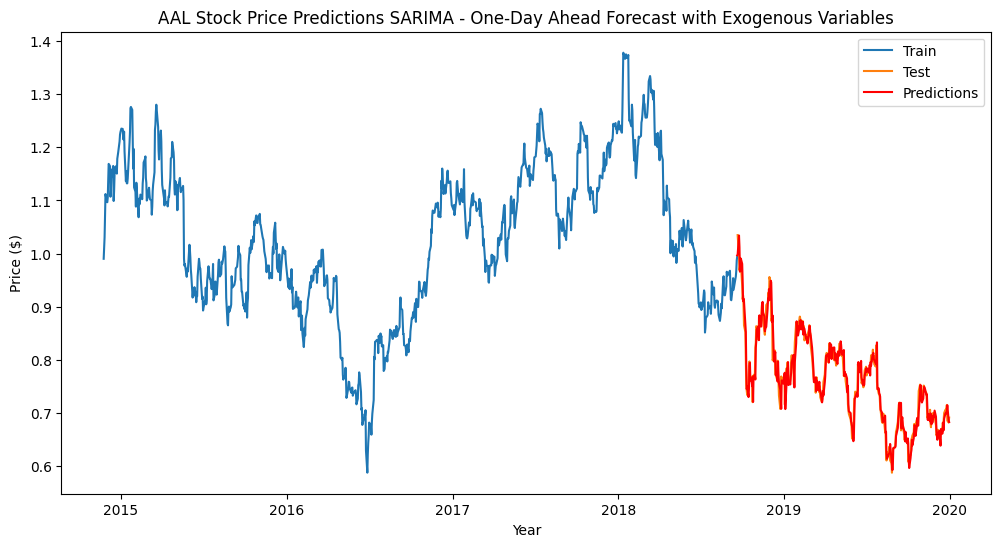

In [58]:
plot_predictions(train, test, oda_pred_exogenous['Prediction'], 'SARIMA - One-Day Ahead Forecast with Exogenous Variables')

In [59]:
oda_rmse_exogenous = calc_rmse(test, oda_pred_exogenous['Prediction'])
print(f'RMSE of One-Day Ahead Forecast with Exogenous Variables: {oda_rmse_exogenous}')

RMSE of One-Day Ahead Forecast with Exogenous Variables: 0.020397344413191087


### One Week Ahead

In [60]:
fda_pred_exogenous = h_step_prediction_exogenous(5, train, test, exogenous_train, exogenous_test, copy.deepcopy(AAL_exogenous_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

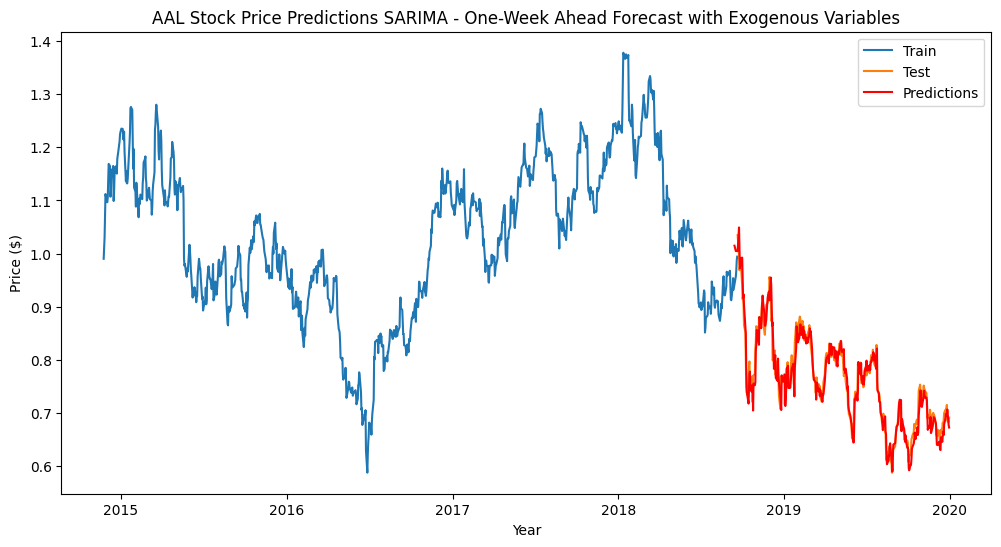

In [61]:
plot_predictions(train, test, fda_pred_exogenous['Prediction'], 'SARIMA - One-Week Ahead Forecast with Exogenous Variables')

In [62]:
rmse_fda_exogenous = calc_rmse(test, fda_pred_exogenous['Prediction'])
print(f'RMSE of One-Week Ahead Forecast with Exogenous Variables: {rmse_fda_exogenous}')

RMSE of One-Week Ahead Forecast with Exogenous Variables: 0.022277748991636006


### One Month Ahead

In [63]:
oma_pred_exogenous = h_step_prediction_exogenous(21, train, test, exogenous_train, exogenous_test, copy.deepcopy(AAL_exogenous_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

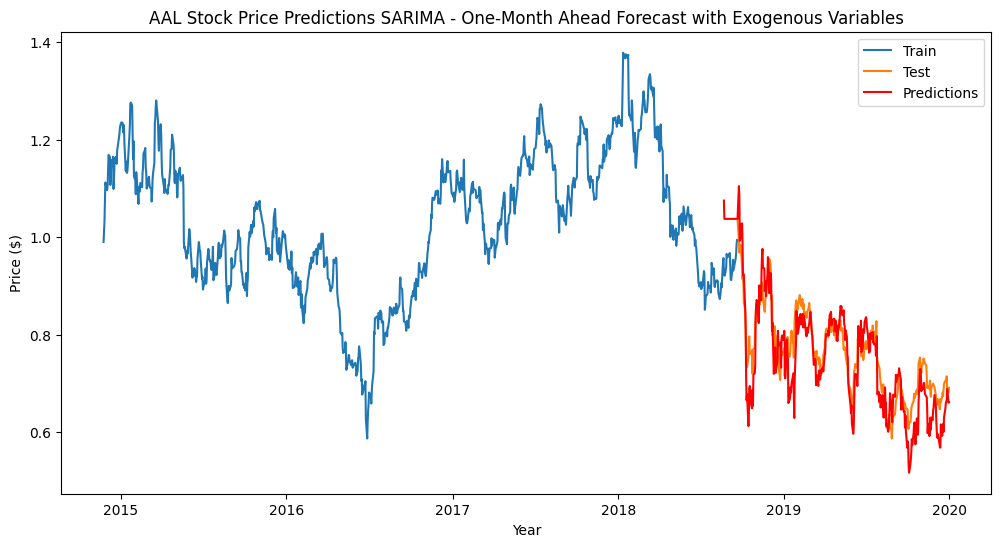

In [64]:
plot_predictions(train, test, oma_pred_exogenous['Prediction'], 'SARIMA - One-Month Ahead Forecast with Exogenous Variables')

In [65]:
rmse_oma_exogenous = calc_rmse(test, oma_pred_exogenous['Prediction'])
print(f'RMSE of One-Month Ahead Forecast with Exogenous Variables: {rmse_oma_exogenous}')

RMSE of One-Month Ahead Forecast with Exogenous Variables: 0.05227481819472532


## Saving all Predictions

In [66]:
# Saving all Predictions to CSV files
oda_pred.to_csv('predictions_yarden/oda_pred.csv')
fda_pred.to_csv('predictions_yarden/fda_pred.csv')
oma_pred.to_csv('predictions_yarden/oma_pred.csv')
oda_pred_exogenous.to_csv('predictions_yarden/oda_pred_exogenous.csv')
fda_pred_exogenous.to_csv('predictions_yarden/fda_pred_exogenous.csv')
oma_pred_exogenous.to_csv('predictions_yarden/oma_pred_exogenous.csv')

## Trading Strategy

In [67]:
data = pd.read_csv('data_final/with_xal.csv')
test = data[data['set'] == 'test']
oma_pred = pd.read_csv('predictions_yarden/oma_pred.csv')

In [68]:
true_values = list(test['Close'])
H = 21
yhat_lower = list(oma_pred['Lower_CI'])
yhat_upper = list(oma_pred['Upper_CI'])

# move yhat_lower and yhat_upper back by H steps
yhat_lower = yhat_lower[H:]
yhat_upper = yhat_upper[H:]

In [69]:
import numpy as np
import yfinance as yf
import pandas as pd

# Parameters for fees and premiums
fee_percent = 0.001  # 0.1% transaction fee
short_premium_daily = 0.0005  # 0.05% daily borrowing cost for shorting

# Trading strategy variables
free = 0  # To track the index until which no further trades can be made
money = 100.0  # Initial cash balance
shares = 0.0  # Number of shares currently held
shorted_shares = 0.0  # Number of shares currently shorted
portfolio_values = []  # To track portfolio values over time

# Assuming x_test contains the dates for the evaluation period, add last 21 dates of train to test
dates = test['Date']
print("Start date:", dates.iloc[0])

# Fetch S&P 500 data using yfinance
sp500_data = yf.download('^GSPC', start=dates.min(), end=dates.max())
sp500_data = sp500_data.reindex(dates, method='nearest')  # Align to x_test dates

# Get the adjusted close prices for the benchmark
sp500_prices = sp500_data['Adj Close']

# Benchmark: Initial investment in S&P 500
sp500_money = 100.0  # Same initial investment
sp500_shares = sp500_money / sp500_prices.iloc[0]  # Buy S&P 500 at the first price
sp500_portfolio_values = sp500_shares * sp500_prices  # Track S&P 500 portfolio values

print("Length of yhat_lower:", len(yhat_lower), "Length of true_values:", len(true_values))

# Execute the trading strategy
for i in range(len(dates)):
    # print(portfolio_value)  # Ensure we don't go out of bounds
    # print(f"shorted shares: {shorted_shares}")
    if free < i:
        # Case 1: Buy when yhat_lower is above the actual price
        if i < len(yhat_lower) and yhat_lower[i] > true_values[i]:
            free = i + 21  # Lock the trading window for 21 days
            shares = money / true_values[i]  # Calculate shares to buy
            
            # Deduct the transaction cost for buying
            transaction_fee = shares * true_values[i] * fee_percent
            money -= shares * true_values[i] + transaction_fee

            print(f"Buying at {true_values[i]} on {dates.iloc[i]}, since yhat_lower is {yhat_lower[i]}")
            
        # Case 2: Short when yhat_upper is below the actual price
        elif i < len(yhat_lower) and yhat_upper[i] < true_values[i]:
            free = i + 21  # Lock the trading window for 21 days
            shorted_shares = money / true_values[i]  # Calculate shares to short
            
            # Add proceeds from short sale, deducting the transaction cost
            short_revenue = shorted_shares * true_values[i]
            transaction_fee = short_revenue * fee_percent
            money += short_revenue - transaction_fee

            print(f"Shorting at {true_values[i]} on {dates.iloc[i]}, since yhat_upper is {yhat_upper[i]}")

    # Dynamically update portfolio value
    if shares > 0:  # If holding stocks
        portfolio_value = money + shares * true_values[i]
    elif shorted_shares > 0:  # If holding a short position
        portfolio_value = money - shorted_shares * true_values[i]  # Liability from short
        portfolio_value -= shorted_shares * true_values[i] * short_premium_daily  # Daily short premium cost
    else:
        portfolio_value = money  # Cash only

    portfolio_values.append(portfolio_value)

    # Finalize the trade after 21 days
    if free == i:
        if shares > 0:  # Sell the held shares
            sell_revenue = shares * true_values[i]
            transaction_fee = sell_revenue * fee_percent
            money += sell_revenue - transaction_fee
            print(f"Selling at {true_values[i]} on {dates.iloc[i]}")
            shares = 0
        elif shorted_shares > 0:  # Buy back the shorted shares
            buy_back_cost = shorted_shares * true_values[i]
            transaction_fee = buy_back_cost * fee_percent
            premium_cost = shorted_shares * true_values[i] * short_premium_daily * 30
            money -= buy_back_cost + transaction_fee + premium_cost
            print(f"Buying back at {true_values[i]} on {dates.iloc[i]}")
            shorted_shares = 0

# Final cash balance of the trading strategy
final_strategy_balance = money
print("Final cash balance from strategy:", final_strategy_balance)

# Final cash balance from holding S&P 500
final_sp500_balance = sp500_shares * sp500_prices.iloc[-1]
print("Final cash balance from holding S&P 500:", final_sp500_balance)

# Convert portfolio values to a pandas series for easier calculations
portfolio_values = pd.Series(portfolio_values, index=dates[:len(portfolio_values)])
sp500_portfolio_values = sp500_shares * sp500_prices  # Already a Series

# Helper function to calculate risk measures
def calculate_metrics(portfolio_values, risk_free_rate=0.01):
    # Daily returns
    daily_returns = portfolio_values.pct_change().dropna()

    # Sharpe Ratio
    excess_returns = daily_returns - (risk_free_rate / 252)
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

    # Sortino Ratio
    downside_returns = daily_returns[daily_returns < 0]
    sortino_ratio = np.sqrt(252) * excess_returns.mean() / downside_returns.std()

    # Maximum Drawdown
    cumulative_returns = (1 + daily_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

    return sharpe_ratio, sortino_ratio, max_drawdown

# Calculate metrics for both strategies
strategy_sharpe, strategy_sortino, strategy_mdd = calculate_metrics(portfolio_values)
sp500_sharpe, sp500_sortino, sp500_mdd = calculate_metrics(sp500_portfolio_values["^GSPC"])

# Print results
print("\n--- Risk Measures ---")
print("Strategy:")
print(f"Sharpe Ratio: {strategy_sharpe:.2f}")
print(f"Sortino Ratio: {strategy_sortino:.2f}")
print(f"Maximum Drawdown: {strategy_mdd:.2%}")

print("\nS&P 500:")
print(f"Sharpe Ratio: {sp500_sharpe:.2f}")
print(f"Sortino Ratio: {sp500_sortino:.2f}")
print(f"Maximum Drawdown: {sp500_mdd:.2%}")

ModuleNotFoundError: No module named 'yfinance'